In [9]:
import os
import numpy as np
import pandas as pd
import pprint as pp
import random
import rapidfuzz
# functions for reading data from codenet:
import codenet_reader

In [12]:
# Functions for processing solutions of a problem


def process_pid(pid: str, data_map: dict, do_print=False):
    num_python_solutions = len(codenet_reader.python_solutions(pid))
    if num_python_solutions <= 5:
        return

    df = codenet_reader.init_metadata_df(pid)
    if df is None:
        print("ERROR: Problem metadata could not be loaded!" + f"\n(problem ID: {pid})\n")
        return

    df_accepted = df.loc[df["status"] == "Accepted"]
    # ONLY sample from solutions that are actually wrong
    df_rejected = df.loc[df["status"] == "Wrong Answer"]

    # TODO: use a log file for this otherwise changes get too long!
    if do_print:
        print(f"{pid}", "-" * 50)
        print(" accepted:", df_accepted.shape[0])
        print(" rejected:", df_rejected.shape[0])

    # NOTE: at least 2 rows of both accepted and rejected examples, otherwise triplets can't be formed
    if min(df_accepted.shape[0], df_rejected.shape[0]) < 2:
        return

    half = df_accepted.shape[0] // 2
    # all accepted IDs
    sr_accepted = df_accepted["submission_id"]
    sr_accepted = sr_accepted[: 2 * half]
    # all rejected IDs
    sr_rejected = df_rejected["submission_id"]

    anchors = sr_accepted[:half]
    positives = sr_accepted[half:]
    negatives = sr_rejected[:half]
    
    clip_len = min(map(len, [anchors, positives, negatives]))
    df_triplets = pd.DataFrame(
        {
            "sid_a": anchors[:clip_len].to_list(),
            "sid_p": positives[:clip_len].to_list(),
            "sid_n": negatives[:clip_len].to_list(),
        }
    )
    if do_print:
        pp.pp(df_triplets)

    def create_triplet(pid, sid_a, sid_p, sid_n):
        return {
            "pid": pid,
            "sid_a": sid_a,
            "sid_p": sid_p,
            "sid_n": sid_n,
            "src_a": codenet_reader.read_solution_file(pid, sid_a),
            "src_p": codenet_reader.read_solution_file(pid, sid_p),
            "src_n": codenet_reader.read_solution_file(pid, sid_n),
        }

    data_map[pid] = [
        create_triplet(pid, row["sid_a"], row["sid_p"], row["sid_n"])
        for _, row in df_triplets.iterrows()
    ]

In [15]:
process_pid("p03200", {}, do_print=True)

p03200 --------------------------------------------------
 accepted: 612
 rejected: 103
          sid_a       sid_p       sid_n
0    s489804449  s493799177  s646064465
1    s275384173  s759216400  s561793959
2    s965328448  s032095552  s925737691
3    s702231593  s671450990  s214848410
4    s866302073  s615595457  s773870702
..          ...         ...         ...
98   s470837495  s725049793  s000813546
99   s046950021  s439737521  s630000223
100  s586871935  s073998789  s926955575
101  s169020952  s687651008  s533181048
102  s683899038  s694184192  s978484329

[103 rows x 3 columns]


In [16]:
# Reading data

SAMPLE_SIZE = 2000  # Number of problems to sample from

_pids = os.listdir(codenet_reader.DATA_PATH)
_pids = random.sample(_pids, k=min(SAMPLE_SIZE, len(_pids)))

data_map = {}

print("Starting...")
print(f"Processing {len(_pids)} problems.")

for _pid in _pids:
    process_pid(_pid, data_map=data_map)

print("Data gathered...")

output = []
for pid in data_map:
    for data in data_map[pid]:
        output.append(
            (
                pid,
                data["sid_a"],
                data["sid_p"],
                data["sid_n"],
                data["src_a"],
                data["src_p"],
                data["src_n"],
            )
        )

print(f"TRIPLETS created... LENGTH: {len(output)}")
output = sorted(set(output), key=lambda x: x[0])  # Sort by problem ID
print(f"TRIPLETS filtered... LENGTH: {len(output)}")
print("DONE")

columns = ["pid", "sid_a", "sid_p", "sid_n", "src_a", "src_p", "src_n"]

df_output = pd.DataFrame(output, columns=columns)

Starting...
Processing 2000 problems.
Data gathered...
TRIPLETS created... LENGTH: 138145
TRIPLETS filtered... LENGTH: 138145
DONE


In [17]:
MAX_CHAR_COUNT = 4096
# Filter to pairs that have a combined length of less than `MAX_CHAR_COUNT` characters
filter = lambda row: min(map(len, [row["src_a"], row["src_p"], row["src_n"]])) < MAX_CHAR_COUNT
df_output = df_output[df_output.apply(filter, axis=1)]
print(df_output.shape)

(138102, 7)


In [ ]:
# Calculating rapid fuzz

def run_rf(a,b): return rapidfuzz.fuzz.ratio(a,b)

df_output['pos_rf_ratio'] = df_output.apply(lambda row: run_rf(row['src_a'], row['src_p']), axis=1)
df_output['neg_rf_ratio'] = df_output.apply(lambda row: run_rf(row['src_a'], row['src_n']), axis=1)

In [19]:
# Rapid fuzz counts
print('pos rf gt 80%:', (df_output['pos_rf_ratio']>80).sum())
print('neg rf gt 80%:', (df_output['neg_rf_ratio']>80).sum())

pos rf gt 80%: 5488
neg rf gt 80%: 3588


Text(0.5, 0, 'rf ratio on positive pairs')

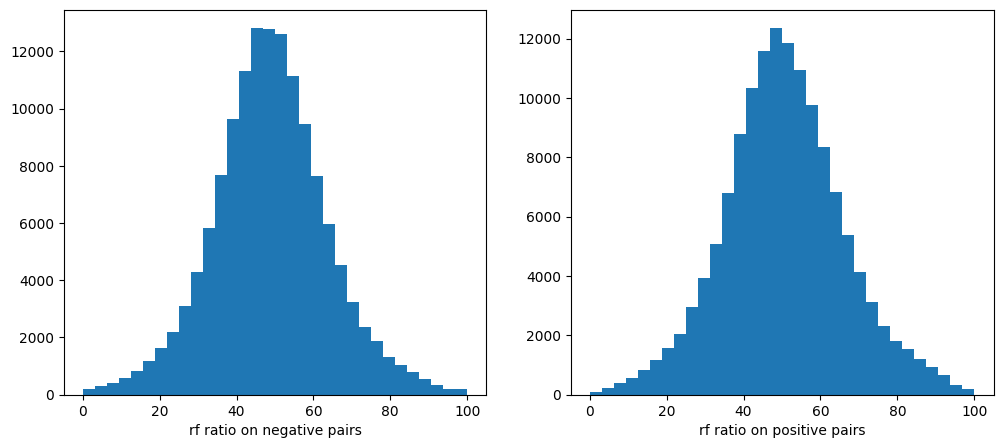

In [20]:
# Rapid fuzz histograms
import matplotlib.pyplot as plt
res = 32
# histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].hist(df_output['neg_rf_ratio'], bins=res)
ax[0].set_xlabel('rf ratio on negative pairs')
ax[1].hist(df_output['pos_rf_ratio'], bins=res)
ax[1].set_xlabel('rf ratio on positive pairs')

In [21]:
NUM_TRIPLETS = 100_000
# Filtering and sampling
df_output = df_output.sample(NUM_TRIPLETS)

In [22]:
# Exporting
EXPORTED_FILE_NAME = '100k_triplets.csv'
df_output = df_output[columns]
df_output.to_csv(EXPORTED_FILE_NAME, index=None)

In [23]:
df = pd.read_csv(EXPORTED_FILE_NAME)
print("Sampled", len(set(df['pid'])), "problems.")
df

Sampled 601 problems.


,pid,sid_a,sid_p,sid_n,src_a,src_p,src_n
0,p02761,s339736267,s513463334,s283980794,"n,m = map(int,input().split())\nans = [0]*n\nf...","def solve(string):\n n, m, *sc = map(int, s...","N, M = map(int, input().split())\nd = {}\nfor ..."
1,p02817,s274579408,s815715548,s624715198,"s, t = input().split()\nprint(t + s)",i = input().split()\nS = i[0]\nT = i[1]\nprint...,"s,t = input().split()\nprint(s+t)"
2,p02660,s330236290,s087362375,s684007231,def divideprime(n):\n ret = []\n i = 2\n...,def factorization(n):\n arr = []\n temp ...,N=int(input())\n\ndef factorization(n):\n a...
3,p03163,s921055666,s964277098,s817281047,"import numpy as np\n\nn, w = map(int, input()....","N,W = list(map(int,input().split()))\n\nw = []...","#4\nN,W=map(int,input().split())\nA=[[0]]+[[in..."
4,p03206,s939488138,s337592785,s157645994,"d=int(input())\nprint(""Christmas "",end="""")\nif...",d=int(input())\nc='Christmas'\ne=' Eve'\nprint...,"D = input ()\nif D == 25:\n print ""Christma..."
...,...,...,...,...,...,...,...
99995,p02574,s141696368,s469778042,s127411190,#!/usr/bin/env python\nimport math\n\nn = int(...,import math\nfrom functools import reduce\n\n\...,def gcd_all(A):\n from math import gcd\n ...
99996,p03284,s008777616,s097946515,s219308355,"n,k = map(int,input().split())\nmn = n//k\npri...","n,k = map(int,input().split())\nif n % k == 0:...","a,b=map(int,input().split())\nprint(int(a%b))"
99997,p02623,s101385408,s269876894,s118190940,"n,m,k=map(int,input().split())\na=list(map(int...",import sys\nsys.setrecursionlimit(10**8)\ninpu...,"def main():\n N, M, K = map(int, input().spli..."
99998,p03607,s455119114,s514947352,s223212725,N = int(input())\nnums = {}\nfor i in range(N)...,from collections import Counter\nn = int(input...,n = int(input())\nls = []\n\nfor i in range(n)...
